In [1]:
# Importar librerias
import requests                    
import pandas as pd
import time             
import matplotlib.pyplot as plt    
import seaborn as sns               
import numpy as np                  
import datetime
import json
from bs4 import BeautifulSoup
from selenium import webdriver
import re
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.colors as colors
from geopy.geocoders import Nominatim

## "Chile."

Los datos sísmicos se descargaron a través de [USGS](https://earthquake.usgs.gov/fdsnws/event/1/) (El Servicio Geologico de los Estados Unidos ).

El analisis se realiza en un intervalo de inicio el 01 de enero de 2023 y fin el 11 de mayo de 2023, o sea en un periodo de 130 días.

In [2]:

periodo_en_dias = (datetime.datetime(2023,5,11) - datetime.datetime(2023,1,1)).days
print('El periodo en días es igual a',periodo_en_dias,'días')

El periodo en días es igual a 130 días


Realizar la extraccion y creacion del DataFrame desde el enlace.

In [3]:
    
def extraccion_chile():
    
    chile = 'https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2023-01-01%2000:00:00&endtime=2023-05-11%2023:59:59&maxlatitude=-17.5&minlatitude=-56.0&maxlongitude=-66.0&minlongitude=-81.0&minmagnitude=1&orderby=time-asc'

    # Hacemos un request porque hay json anidados
    chile = requests.get(chile).json()
    # el diccionario de features es el que tiene la infomación
    chile = pd.json_normalize(chile, record_path =['features'])

    return chile

chile = extraccion_chile()

Visualizar los primeros elementos del DataFrame.

In [4]:
chile.head()

,type,id,properties.mag,properties.place,properties.time,properties.updated,properties.tz,properties.url,properties.detail,properties.felt,...,properties.types,properties.nst,properties.dmin,properties.rms,properties.gap,properties.magType,properties.type,properties.title,geometry.type,geometry.coordinates
0,Feature,us7000j1ew,4.8,"68 km S of Calama, Chile",1672575539423,1678575089040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.0,...,",dyfi,earthquake-name,moment-tensor,origin,pha...",47,0.696,0.81,80,mwr,earthquake,"M 4.8 - 68 km S of Calama, Chile",Point,"[-68.9221, -23.0742, 106.733]"
1,Feature,us7000j1f6,4.1,"136 km N of Calama, Chile",1672579649461,1678575090040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,",origin,phase-data,",28,0.522,0.76,55,mb,earthquake,"M 4.1 - 136 km N of Calama, Chile",Point,"[-68.9621, -21.2221, 90.462]"
2,Feature,us7000j1h7,4.4,"Potosi, Bolivia",1672608764421,1678575090040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,",origin,phase-data,",47,1.862,0.69,40,mb,earthquake,"M 4.4 - Potosi, Bolivia",Point,"[-67.2105, -21.3126, 201.911]"
3,Feature,us7000j1jc,4.5,"62 km W of San Antonio de los Cobres, Argentina",1672641913694,1678575091040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,",origin,phase-data,",84,1.637,0.84,43,mb,earthquake,"M 4.5 - 62 km W of San Antonio de los Cobres, ...",Point,"[-66.9233, -24.1203, 195.266]"
4,Feature,us7000j1li,4.5,"25 km ENE of San Martín, Argentina",1672658649437,1678575092040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,",origin,phase-data,",43,0.417,0.53,120,mb,earthquake,"M 4.5 - 25 km ENE of San Martín, Argentina",Point,"[-68.2466, -31.3613, 105.312]"


_Transformacion._

Cambiar el nombre de las columnas y quitar properties de los nombres de columnas.

In [5]:
def cambiar_quitar(pais):

    columnas = [p.replace('properties.', '') for p in pais.columns.to_list()]
    new_names = dict(zip(pais.columns.to_list(), columnas))

    pais = pais.rename(new_names, axis='columns')

    return pais

chile = cambiar_quitar(chile)

Filtrar valores de la variable __place__ para valores solamente de Chile.

In [6]:
chile = chile[chile.place.str.contains('Chile',na=False)]

Determinar el significado de cada variable.

El significado de las 30 variables se ubica en el siguiente [link](https://earthquake.usgs.gov/data/comcat/data-eventterms.php).

La siguiente grafica determina que existen valores faltantes para las variables __tz__, __felt__, __cdi__, __mmi__ y __alert__.

Text(0.5, 1.0, 'Porcentaje de datos por variable')

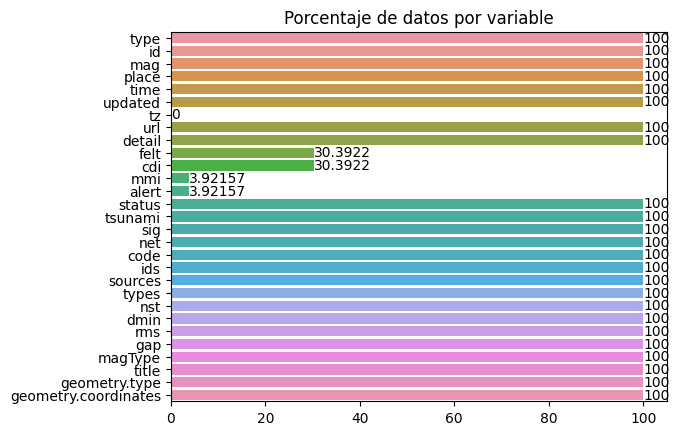

In [7]:
def datos_faltantes(pais):
    ax = sns.barplot(x = (pais.notnull().sum()*100/pais.shape[0]).values, y = pais.columns)
    ax.bar_label(ax.containers[0])
    return plt.title('Porcentaje de datos por variable')

datos_faltantes(chile)

In [8]:
print('El total de sismos en 130 días de Chile es', chile.shape[0])
print('La menor magnitud registrada es', chile.mag.min())
print('La mayor magnitud registrada es',chile.mag.max())

El total de sismos en 130 días de Chile es 204
La menor magnitud registrada es 3.6
La mayor magnitud registrada es 6.3


Eliminar variables innecesarias para el modelo.

In [9]:
def eliminar_variables(pais):
    variables = ['type', 'id', 'updated', 'tz', 'url', 'detail', 'felt', 'cdi', 'mmi', 'alert', 'status', 
            'tsunami', 'sig', 'net', 'code', 'ids', 'sources', 'types' , 'nst', 'dmin', 'rms', 
            'gap', 'magType', 'type', 'title', 'geometry.type'] 

    pais = pais.drop(variables, axis='columns')

    return pais

chile = eliminar_variables(chile)

Separar las variables de coordenadas en longitud, latitud y profundidad.

In [10]:
def sep_coordenadas(pais):
    pais.rename({'geometry.coordinates':'coordinates'}, axis='columns', inplace=True)
    pais[['longitude','latitude', 'depth']] = pd.DataFrame(pais.coordinates.tolist(), index= pais.index)
    pais.drop('coordinates',axis=1, inplace= True)
    return pais

sep_coordenadas(chile)

,mag,place,time,longitude,latitude,depth
0,4.8,"68 km S of Calama, Chile",1672575539423,-68.9221,-23.0742,106.733
1,4.1,"136 km N of Calama, Chile",1672579649461,-68.9621,-21.2221,90.462
5,4.1,"32 km NE of Arica, Chile",1672711794544,-70.0597,-18.2870,85.305
9,4.5,"66 km S of Calama, Chile",1672846177261,-68.9523,-23.0579,106.604
10,4.0,"33 km WSW of Ovalle, Chile",1672861375191,-71.4941,-30.7554,35.000
...,...,...,...,...,...,...
295,4.1,"76 km WNW of Diego de Almagro, Chile",1683675580334,-70.7297,-26.0898,77.792
296,4.3,"73 km E of Taltal, Chile",1683747948630,-69.7566,-25.3745,73.849
297,4.2,"93 km E of La Tirana, Chile",1683796484854,-68.7728,-20.4478,118.507
298,4.0,"38 km W of Camiña, Chile",1683823977459,-69.7845,-19.2581,85.701


Formatear la variable __time__.

In [11]:
def formato_tiempo(pais):
    def formatear_time(x):

        time = x/1000
        return datetime.datetime.fromtimestamp(time)

    pais.time = pais.time.apply(formatear_time)

    return pais

formato_tiempo(chile)

,mag,place,time,longitude,latitude,depth
0,4.8,"68 km S of Calama, Chile",2023-01-01 09:18:59.423,-68.9221,-23.0742,106.733
1,4.1,"136 km N of Calama, Chile",2023-01-01 10:27:29.461,-68.9621,-21.2221,90.462
5,4.1,"32 km NE of Arica, Chile",2023-01-02 23:09:54.544,-70.0597,-18.2870,85.305
9,4.5,"66 km S of Calama, Chile",2023-01-04 12:29:37.261,-68.9523,-23.0579,106.604
10,4.0,"33 km WSW of Ovalle, Chile",2023-01-04 16:42:55.191,-71.4941,-30.7554,35.000
...,...,...,...,...,...,...
295,4.1,"76 km WNW of Diego de Almagro, Chile",2023-05-09 20:39:40.334,-70.7297,-26.0898,77.792
296,4.3,"73 km E of Taltal, Chile",2023-05-10 16:45:48.630,-69.7566,-25.3745,73.849
297,4.2,"93 km E of La Tirana, Chile",2023-05-11 06:14:44.854,-68.7728,-20.4478,118.507
298,4.0,"38 km W of Camiña, Chile",2023-05-11 13:52:57.459,-69.7845,-19.2581,85.701


Crear variables __date__ y __time_hour__.

In [12]:
def crear_variables_time(pais):
    pais['date'] = pais.time.dt.date
    pais['time_hour'] = pais.time.dt.time
    pais['time_hour'] = pais['time_hour'].apply(lambda x: x.replace(microsecond=0))

    return pais

crear_variables_time(chile)

,mag,place,time,longitude,latitude,depth,date,time_hour
0,4.8,"68 km S of Calama, Chile",2023-01-01 09:18:59.423,-68.9221,-23.0742,106.733,2023-01-01,09:18:59
1,4.1,"136 km N of Calama, Chile",2023-01-01 10:27:29.461,-68.9621,-21.2221,90.462,2023-01-01,10:27:29
5,4.1,"32 km NE of Arica, Chile",2023-01-02 23:09:54.544,-70.0597,-18.2870,85.305,2023-01-02,23:09:54
9,4.5,"66 km S of Calama, Chile",2023-01-04 12:29:37.261,-68.9523,-23.0579,106.604,2023-01-04,12:29:37
10,4.0,"33 km WSW of Ovalle, Chile",2023-01-04 16:42:55.191,-71.4941,-30.7554,35.000,2023-01-04,16:42:55
...,...,...,...,...,...,...,...,...
295,4.1,"76 km WNW of Diego de Almagro, Chile",2023-05-09 20:39:40.334,-70.7297,-26.0898,77.792,2023-05-09,20:39:40
296,4.3,"73 km E of Taltal, Chile",2023-05-10 16:45:48.630,-69.7566,-25.3745,73.849,2023-05-10,16:45:48
297,4.2,"93 km E of La Tirana, Chile",2023-05-11 06:14:44.854,-68.7728,-20.4478,118.507,2023-05-11,06:14:44
298,4.0,"38 km W of Camiña, Chile",2023-05-11 13:52:57.459,-69.7845,-19.2581,85.701,2023-05-11,13:52:57


Eliminar variable __time__.

In [13]:
chile.drop('time', axis='columns', inplace=True)

Renombrar las variables.

In [14]:
chile.rename({'mag':'magnitude', 'time_hour':'time'}, axis='columns', inplace=True)

Analizar el formato.

In [18]:
chile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 306
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  206 non-null    float64
 1   place      206 non-null    object 
 2   longitude  206 non-null    float64
 3   latitude   206 non-null    float64
 4   depth      206 non-null    float64
 5   date       206 non-null    object 
 6   time       206 non-null    object 
dtypes: float64(4), object(3)
memory usage: 12.9+ KB


Graficar para hallar valores unicos.

Text(0.5, 1.0, 'Cantidad de valores únicos por variable')

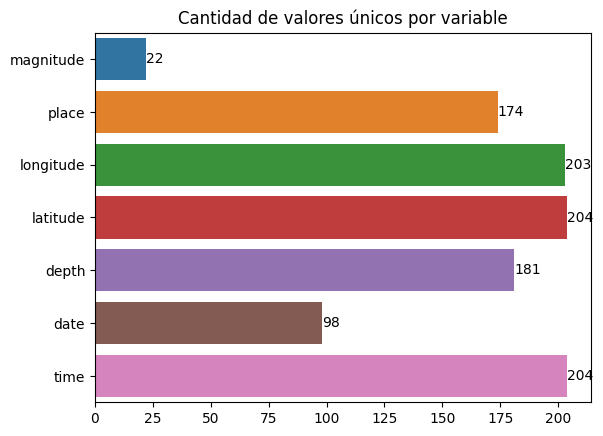

In [15]:
def valor_unico(pais):
    ax = sns.barplot(x = pais.nunique().values, y = pais.columns)
    ax.bar_label(ax.containers[0])
    return plt.title('Cantidad de valores únicos por variable')

valor_unico(chile)

El mapa de correlaciones determina que no existe correlacion lineal entre variables.

Text(0.5, 1.0, 'Mapa de correlacion')

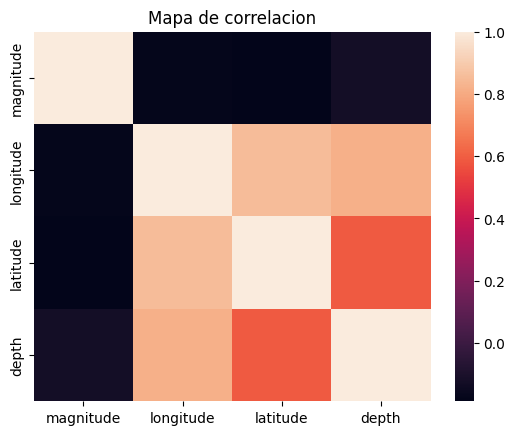

In [75]:
def mapa_correlacion(pais):

    sns.heatmap(pais.corr(numeric_only=True))
    return plt.title('Mapa de correlacion')

mapa_correlacion(chile)

Los siguientes graficos determinan la distribucion sismica por region y la magnitude predominante: alrededor de 4.3 grados.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_6080\2585962117.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'),bbox=(-75.6443953112, -55.61183, -66.95992, -17.5800118954))


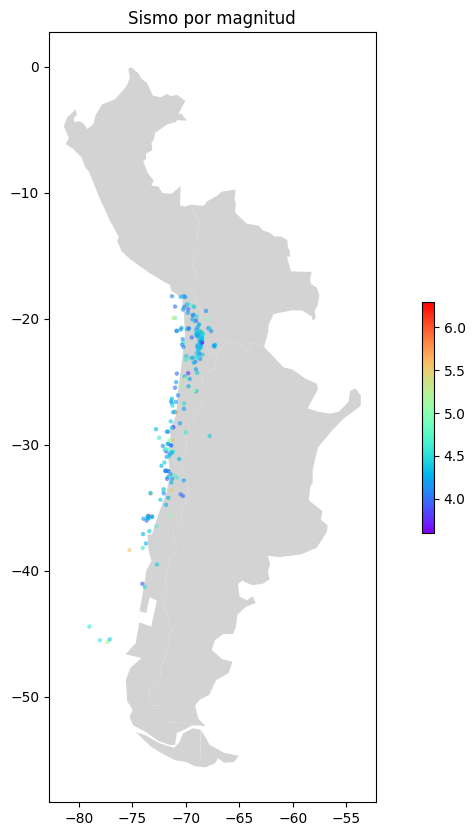

In [16]:

def mapa_sismo(pais):
    # https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    # Escogemos el mapa
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'),bbox=(-75.6443953112, -55.61183, -66.95992, -17.5800118954))
    # Creamos el objeto geodataframe
    crs = 'EPSG:4326'
    geometry = [Point(xy) for xy in zip(pais['longitude'], pais['latitude'])]
    geo_df = gpd.GeoDataFrame(pais, 
                            crs = crs, 
                            geometry = geometry)

    # por magnitud
    fig, ax = plt.subplots(figsize = (12,10))

    world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

    geo_df.plot(column = 'magnitude', ax=ax, cmap = 'rainbow',
                legend = True, legend_kwds={'shrink': 0.3}, 
                markersize = 5, alpha=0.5)
                
    ax.set_title('Sismo por magnitud')

mapa_sismo(chile)

C:\Users\Edwar\AppData\Local\Temp\ipykernel_9728\4281014579.py:3: UserWarning: 
The palette list has fewer values (10) than needed (6105) and will cycle, which may produce an uninterpretable plot.
  return sns.displot(pais, x="magnitude",hue='place',multiple="stack",kde=True,palette=sns.color_palette('bright')[:13])


KeyboardInterrupt: 

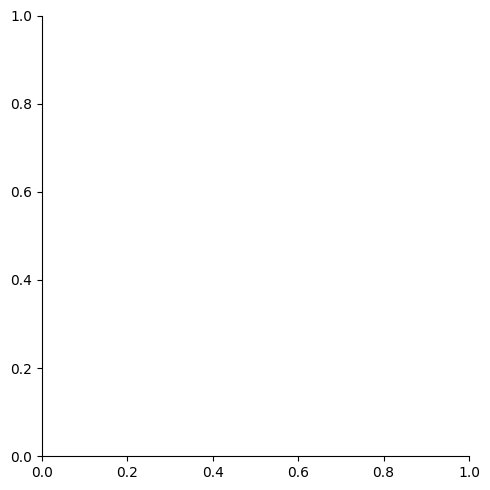

In [ ]:

def magnitud_region(pais):
    
    return sns.displot(pais, x="magnitude",hue='place',multiple="stack",kde=True,palette=sns.color_palette('bright')[:13])

magnitud_region(chile)

Extraer y crear la variable __distancia__ de la variable __place__. 

In [17]:

def separate_date(row):
    part = row.place.split(" ")
    row['distancia'] = part[0]
    return row
chile = chile.apply(separate_date, axis=1)

Cambiar el _type_ de variable a _int_ de la variable __distancia__.

In [18]:
def replace_as_0(row):
    try:
        int(row['distancia'])
    except:
        row['dist'] = 100000
    else:
        row['dist'] = int(row['distancia'])
    return row
chile = chile.apply(replace_as_0, axis=1)
chile.drop('distancia',axis=1,inplace=True)
chile.rename({'dist':'distancia'}, axis='columns', inplace=True)

Eliminar la variable __place__.

In [19]:
chile.drop('place',axis=1,inplace=True)

Crear la columna __codigo_region__.

In [24]:
def codigo_region(row):
    point = row.latitude,row.longitude
    geolocator = Nominatim(user_agent='Google Maps') 
    location = geolocator.reverse(point)
    try:
        location.raw['address']['ISO3166-2-lvl4']
    except:
        row['codigo_region'] = 'Fuera de region'
    else:
        location = location.raw['address']['ISO3166-2-lvl4']
        row['codigo_region'] = str(location)
    return row

chile = chile.apply(codigo_region, axis=1)

Ordenar variables.

In [25]:
def ordenar_vaiables(pais):

    pais = pais[['date','time',	'magnitude','depth','latitude','longitude','distancia','codigo_region']]
    return pais

chile = ordenar_vaiables(chile)

In [21]:
chile.head()

,magnitude,longitude,latitude,depth,date,time,distancia
0,4.8,-68.9221,-23.0742,106.733,2023-01-01,09:18:59,68
1,4.1,-68.9621,-21.2221,90.462,2023-01-01,10:27:29,136
5,4.1,-70.0597,-18.2870,85.305,2023-01-02,23:09:54,32
9,4.5,-68.9523,-23.0579,106.604,2023-01-04,12:29:37,66
10,4.0,-71.4941,-30.7554,35.000,2023-01-04,16:42:55,33


Convertir data frame a json.

Formatear __date__ a string.

In [27]:
def crear_variables_time(pais):
    
    
    pais['date'] = pais['date'].apply(lambda x: str(x))

    return pais

crear_variables_time(chile)

,date,time,magnitude,depth,latitude,longitude,distancia,codigo_region
0,2023-01-01,09:18:59,4.8,106.733,-23.0742,-68.9221,68,CL-AN
1,2023-01-01,10:27:29,4.1,90.462,-21.2221,-68.9621,136,CL-TA
5,2023-01-02,23:09:54,4.1,85.305,-18.2870,-70.0597,32,CL-AP
9,2023-01-04,12:29:37,4.5,106.604,-23.0579,-68.9523,66,CL-AN
10,2023-01-04,16:42:55,4.0,35.000,-30.7554,-71.4941,33,CL-CO
...,...,...,...,...,...,...,...,...
298,2023-05-13,01:51:25,4.6,24.412,-38.0551,-73.6815,37,Fuera de region
300,2023-05-14,18:55:18,4.3,132.498,-24.1120,-67.9895,134,CL-AN
302,2023-05-15,03:18:33,4.3,24.029,-36.8129,-73.7966,61,Fuera de region
305,2023-05-15,16:24:05,4.3,116.644,-20.0678,-69.1629,59,CL-TA


Guardar datos en un archivo json.

In [29]:
chile_json = chile.to_json(orient = 'records')
with open('datos_chile_etl.json', 'w') as f:
    f.write(chile_json)